In [216]:
# Set-up default environment
%run '../ipython_startup.py'

Importing commonly used libraries: os, sys, numpy as np, scipy as sp, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt
Creating project level variables: MCLAB = /home/jfear/mclab, PROJ = /home/jfear/mclab/cegs_ase_paper, TODAY = 20150721
Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
# Additional Imports
import sas7bdat

In [218]:
# Import clean Stack data from SAS (See Makefile_ase_summarize.sas for filtering details)
with sas7bdat.SAS7BDAT(os.path.join(PROJ, 'sas_data/clean_ase_stack.sas7bdat')) as F:
    dfClean = F.to_data_frame()
dfClean.head()

[clean_ase_stack.sas7bdat] header length 65536 != 8192
[clean_ase_stack.sas7bdat] [clean_ase_stack.sas7bdat] header length 65536 != 8192
[clean_ase_stack.sas7bdat] [clean_ase_stack.sas7bdat] [clean_ase_stack.sas7bdat] header length 65536 != 8192


,flag_AI_combined,flag_AI_qsim,flag_all_AI,flag_q4_AI,flag_q5_AI,flag_q6_AI,fusion_id,line,mating_status,mean_apn,q4_mean_theta,q5_mean_theta,q6_mean_theta,qsim_line,qsim_mean_theta,sum_both,sum_line,sum_tester,sum_total
0,0,0,0,1,0,1,F10005_SI,r101,M,29.523922,0.573,0.475,0.379,0.5,0.476,1274,155,133,1562
1,1,1,1,1,1,1,F10136_SI,r101,M,94.156800,0.862,0.812,0.747,0.5,0.812,1526,61,252,1839
2,1,1,1,1,1,1,F10268_SI,r101,M,67.062201,0.746,0.667,0.574,0.5,0.664,658,76,142,876
3,1,1,1,1,1,1,F10317_SI,r101,M,32.648139,0.157,0.110,0.077,0.5,0.112,1909,230,27,2166
4,0,0,0,1,0,0,F10806_SI,r101,M,40.588235,0.679,0.596,0.510,0.5,0.597,969,28,38,1035


In [219]:
# Pivot q5 mean theta to compare M and V
q5sbs = dfClean.pivot_table(values='q5_mean_theta', index=['fusion_id', 'line'], columns='mating_status')
q5sbs.rename(columns={'M': 'q5_M', 'V': 'q5_V'}, inplace=True)

# Pivot Flag AI Combined to compare M and V
AIsbs = dfClean.pivot_table(values='flag_AI_combined', index=['fusion_id', 'line'], columns='mating_status')
AIsbs.rename(columns={'M': 'AI_M', 'V': 'AI_V'}, inplace=True)

# Merge them together
merged = q5sbs.join(AIsbs)
merged.head()

mating_status    q5_M   q5_V  AI_M  AI_V
fusion_id line                          
F10001_SI r324  0.507  0.490     0     0
          r365  0.646  0.542     0     0
          r373  0.589  0.553     0     1
          r427  0.500  0.483     0     0
          r491  0.401  0.501     0     0

In [220]:
# Group by line
grp = merged.groupby(level='line')
grp.ngroups

49

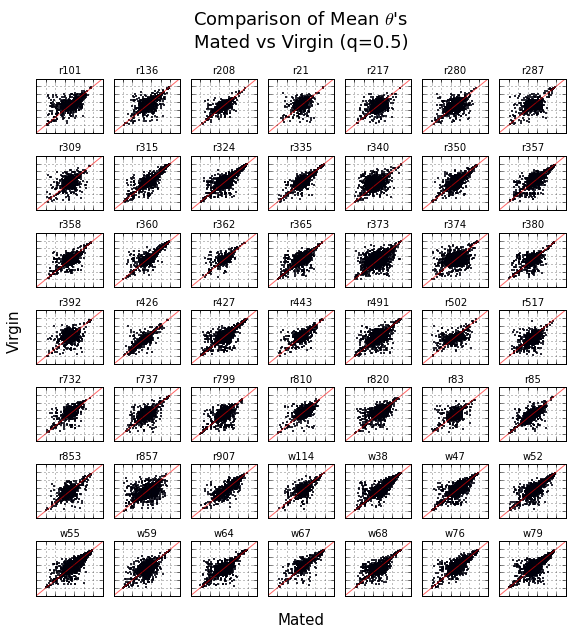

In [221]:
# Panel Plot each line 
fig, axes = plt.subplots(7, 7, figsize=(8.5, 8.5), sharex=True, sharey=True)
axes = np.ravel(axes)
fig.suptitle(r"Comparison of Mean $\theta$'s" + '\nMated vs Virgin (q=0.5)', fontsize=18, x=0.45)
fig.text(0.45, -0.03, 'Mated', ha='center', fontsize=15)
fig.text(-0.03, 0.45, 'Virgin', va='center', rotation='vertical', fontsize=15)

cnt = 0
for line, df in grp:
    ax = axes[cnt]
    df.plot(kind='scatter', x='q5_M', y='q5_V', s=1, ax=ax)
    ax.set_title(line, fontsize=10)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="r", alpha=0.6)
    
    # Hide x and y axis labels
    ax.xaxis.set_ticklabels([]); ax.set_xlabel('')
    ax.yaxis.set_ticklabels([]); ax.set_ylabel('')
    
    cnt += 1   

plt.tight_layout(rect=[0, 0, .90, .90])
fig.savefig(os.path.join(PROJ, 'manuscript/figures/supp_mated_virgin_mean_theta.png'), bbox_inches='tight', dpi=300)

In [222]:
# Plot of two lines r350 and w47
subset = merged.loc[(slice(None), ['r350', 'w47']), :]

# Group by line
grp = subset.groupby(level='line')
grp.ngroups

2

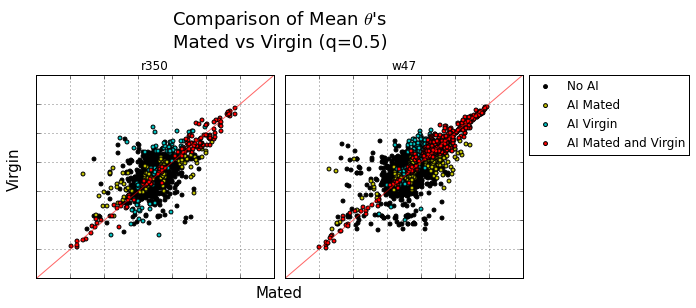

In [223]:
# Panel Plot each line 
fig, axes = plt.subplots(1, 2, figsize=(8.5, 4), dpi=300, sharex=True, sharey=True)
axes = np.ravel(axes)
fig.suptitle(r"Comparison of Mean $\theta$'s" + '\nMated vs Virgin (q=0.5)', fontsize=18, x=0.415)
fig.text(0.415, -0.03, 'Mated', ha='center', fontsize=15)
fig.text(-0.03, 0.415, 'Virgin', va='center', rotation='vertical', fontsize=15)

cnt = 0
for line, df in grp:
    ax = axes[cnt]
    
    noAI = (AIsbs['AI_M'] == 0) & (AIsbs['AI_V'] == 0)
    mAI = (AIsbs['AI_M'] == 1) & (AIsbs['AI_V'] == 0)
    vAI = (AIsbs['AI_M'] == 0) & (AIsbs['AI_V'] == 1)
    bAI = (AIsbs['AI_M'] == 1) & (AIsbs['AI_V'] == 1)
        
    # Set colors: black -> no AI, yellow -> AI in mated, cyan -> AI in virgin, red -> AI in both mated and virgin    
    df[noAI].plot(kind='scatter', x='q5_M', y='q5_V', s=15, ax=ax, c='k', label='No AI')
    df[mAI].plot(kind='scatter', x='q5_M', y='q5_V', s=15, ax=ax, c='y', label='AI Mated')
    df[vAI].plot(kind='scatter', x='q5_M', y='q5_V', s=15, ax=ax, c='c', label='AI Virgin')
    df[bAI].plot(kind='scatter', x='q5_M', y='q5_V', s=15, ax=ax, c='r', label='AI Mated and Virgin')
    
    if cnt == 1:
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, labels, bbox_to_anchor=(1, 1.03), loc=2, scatterpoints=1)
    else:
        ax.legend().remove()
        

    # Set options
    ax.set_title(line, fontsize=12)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="r", alpha=0.6)
    
    # Hide x and y axis labels
    ax.xaxis.set_ticklabels([]); ax.set_xlabel('')
    ax.yaxis.set_ticklabels([]); ax.set_ylabel('')
    
    cnt += 1   

plt.tight_layout(rect=[0, 0, .83, .83])
fig.savefig(os.path.join(PROJ, 'manuscript/figures/mated_virgin_mean_theta.png'), bbox_inches='tight', dpi=300)